# This plots the \Delta T on a map in a given year (2100)
## Run from beginning until the end gives all the pictures

### Used for: 
- Full Figure
    - hom_P-2Pr (historic)
    - hom_P--2Pr (until 2100)
    - hom_single...
   
#### Choose the options:
 - single
 - SSP5 (and opt)
 - historic
 - fut2250
 -!! runname !!
    


In [3]:
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from matplotlib import gridspec
fs=20 #fontsize for labels, legend, ...
font={'family' : 'serif', 'size' : fs} #define font for legend
plt.rc('font', **font)
import cmocean
from mpl_toolkits.basemap import Basemap
# import via conda install basemap (for some reason pip doesnt work)

KeyError: 'PROJ_LIB'

In [73]:
climber_path='/home/peter/PIK/climber/' #/home/peter/PIK/climber/
data_grid=xr.open_dataset(
    climber_path+'data_preparation/snapshots_potsdam2.055623.01.01.dta.nc', 
    decode_times=False)


In [74]:
X,Y = np.meshgrid(np.insert(data_grid.xu_i,0,0), data_grid.yu_j)

In [75]:
def get_time(y):
    return (y+54783-1-1810)*360-0.5

def area_mean_lon(x, lats=data_grid.yt_j, lon=data_grid.xt_i):
    '''x should have dimensions: lat,lon'''
    weights=np.cos(lats*np.pi/180)
    irrelevant,real_weights=np.meshgrid(lon, weights)
    z=real_weights*x
    return np.sum(z)/np.sum(real_weights)
def change_to_Atl(x, grid=data_grid):
    new_x=np.copy(x)
    #print(np.shape(new_x))
    switch=np.where(grid.xt_i>180)[0][0]
    for i in range(0,len(grid.xt_i)):
        if grid.xt_i[i]>180:
            new_x[:,i-switch]=x[:,i]
            #print(i-switch)
        else:
            new_x[:,i+switch]=x[:,i]
            #print(i+switch)
    return new_x
frlnd_atl=change_to_Atl(data_grid.frlnd[0])
X_atl=X-180
Y_atl=Y

In [76]:
def get_P(single, country, fut2250, SSP, opt):
    if single:
        P_folder="../data_preparation/PMIP/P_hum/"
        addendum=country.lower()+"_cell_"
        if country=="AU": P_folder+="txt_file_au_cell_each_yearJul13_13-24"
        elif country=="AM": P_folder+="txt_file_am_cell_each_yearJul13_13-24"
        elif country=="EU": P_folder+="txt_file_eu_cell_each_yearJul13_13-24"
        elif country=="SH": P_folder+="txt_file_sh_cell_each_yearJul13_13-24"
        elif country=="VA": P_folder+="txt_file_va_cell_each_yearJul13_13-24"
        else:
            print("wrong country")
    else:
        P_folder="../data_preparation/PMIP/P_hum/"
        P_folder+="txt_file_each_yearJul13_11-20"
        if SSP: 
            P_folder_fut="../data_preparation/future/"
            if opt=="1WB":
                P_folder_fut+="txt_file_each_yearJul14_16-12opt1"
            else:
                P_folder_fut+="txt_file_each_yearJul14_15-25opt2"
        addendum=""

    P=[]
    maxyear=2101
    if fut2250: maxyear=2251
    P_years=np.arange(1810,maxyear,step=1)
    P2010=np.loadtxt(
                P_folder+"/P_hum_"+addendum+"year2010.dat")
    for y in P_years:
        if y>2010:
            if SSP:
                P.append(np.loadtxt(P_folder_fut+"/P_hum_"+addendum+"year"+str(y)+".dat"))
            else:
                P.append(1.02**(y-2010)*P2010)
        else:
            P.append(np.loadtxt(
                P_folder+"/P_hum_"+addendum+"year"+str(y)+".dat"))
    return P, P_years

In [77]:
def run(mainfolder, reffolder, runname, refname, y, single, SSP, fut2250, historic, country, opt):
    # LOAD FILES
    folder_p=mainfolder+"c3beta_anthrHeat_"+runname+'/'
    folder_ref=reffolder+"c3beta_anthrHeat_"+refname+'/'
    data_ref= xr.open_dataset(folder_ref+"history_p2_short.nc", decode_times=False)
    data_p= xr.open_dataset(folder_p+"history_p2_short.nc", decode_times=False)
    #print((data_p.Time[-1]), (data_ref.Time[-1]))
    # TITLE AND PLOT_NAME
    if SSP:
        growth="SSP5-baseline"
        growthname="SSP"
    elif historic:
        growth="historic"
        growthname="historic"
    else:
        growth="2%-growth"
        growthname="2_perc"
        
    #print("growth: ",growth)

    title_name="Temperature impact of historic data and "+growth+" of $P_{hum}$ after year"+str(y)+'\n'+\
    "using "+runname+" and "+refname

    if single:
        plot_name="dT_map_"+runname+"_"+growthname
    else:
        plot_name="dT_map_sol2_"+runname
        if historic: plot_name+="_historic"
    
    # Load P_hum
    P,P_years=get_P(single, country, fut2250, SSP, opt)

    # MAIN
    diff=data_p.ts_ann.sel(Time=get_time(y))-data_ref.ts_ann.sel(Time=get_time(y))

    return diff, P, P_years, plot_name, growth
    


In [78]:
##################################################
##############     PLOT      #####################
##################################################
def plot(plot_name, y, diff, P,P_years, growth, gyre=False):    
    print("This figure is saved as ", plot_name)
    fig=plt.figure(figsize=(16,9))
    ax=fig.add_subplot(111)

    if y==2100 or y==2010:
        vmax=0.4
    else:
        vmax=0.6
    vmin=-0.0
    #if single: vmax=np.partition(np.array(diff).flatten(), -2)[-2]
    if single: vmax=0.65

    if gyre==True:     
        m = Basemap(projection='cyl',llcrnrlat=data_grid.yu_j[15],urcrnrlat=data_grid.yu_j[-1],\
                        llcrnrlon=180-data_grid.xu_i[12],urcrnrlon=data_grid.xu_i[2],resolution='c')
        m.drawcoastlines()

        plot=ax.pcolormesh(X_atl, Y_atl, change_to_Atl(diff), cmap='bwr', vmin=-0.3, vmax=0.3)

    else:
        m = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
                llcrnrlon=-180,urcrnrlon=180,resolution='c')
        m.drawcoastlines()
        plot=ax.pcolormesh(X_atl, Y_atl, change_to_Atl(diff), cmap='hot_r', vmin=vmin, vmax=vmax)

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.05)

    extend='max'
    if vmax<np.max(diff): 
        extend='max'

    cb=plt.colorbar(plot, cax=cax, extend=extend)#, label="$W/m^2$")
    cb.ax.set_title(r'   $\Delta T \, [{\rm K}]$ ')
    ax.set_title("Year "+str(y)+" ("+growth+")"+r" with $\overline{P_{\rm hum}\cdot {\rm Fr}_{\rm land}}=$"+
                 '%.3f' % area_mean_lon(data_grid.frlnd[0]*P[np.where(P_years==y)[0][0]])+r" ${\rm W/m^2}$"
                +r"$ \rightarrow \overline{\Delta T} = $"+ '%.3f' % area_mean_lon(diff)+r"$\, {\rm K}$")

    if gyre==True:
        ax.set_xticks([X_atl[0,:][len(X_atl[0,:])/4],\
                   X_atl[0,:][len(X_atl[0,:])/2]])
        ax.set_yticks([Y_atl[:,0][len(Y_atl[:,0])/4*3], Y_atl[:,0][-1]])
    else:
        ax.set_xticks([X_atl[0,:][0],X_atl[0,:][len(X_atl[0,:])/4],\
                   X_atl[0,:][len(X_atl[0,:])/2],X_atl[0,:][len(X_atl[0,:])/4*3], X_atl[0,:][-1]])
        ax.set_yticks([Y_atl[:,0][0],Y_atl[:,0][len(Y_atl[:,0])/4],\
                   Y_atl[:,0][len(Y_atl[:,0])/2],Y_atl[:,0][len(Y_atl[:,0])/4*3], Y_atl[:,0][-1]])
    ax.set_xlabel("  ")
    ax.tick_params(axis='both', which='major', labelsize=16)

    grid=data_grid
    crosses_x=[]
    crosses_y=[]
    for i in range(0,16):
        for j in range(0,24):
            a=grid.xt_i[i].values-180
            crosses_x.append(a)
            crosses_y.append(grid.yt_j[j].values)
    ax.plot(crosses_x[:], crosses_y[:], 'x', ms=2, color='black', alpha=0.5)

    if single:
        P_ind=np.where(P[-1]==np.max(P[-1]))
        x_atl_correct_order=-180 * np.floor((grid.xt_i)/180) + (grid.xt_i % 180) 
        ax.plot(x_atl_correct_order[P_ind[1][0]].values, grid.yt_j[P_ind[0][0]].values, 
                'X', ms=15, color='green')

    fig.tight_layout()
    plt.savefig(plot_name+".eps", bbox_inches='tight', format='eps')
    if single:
        print("max P_hum", np.max(P[np.where(P_years==2100)[0][0]]), 
              ", spread on landfrac:", data_grid.frlnd[0][P_ind].values)
    else:
        print("max P_hum", np.max(P[np.where(P_years==2100)[0][0]]))
    print("max Temperature difference:", np.max(diff.values) )
    
    #return change_to_Atl(diff)
    return

In [79]:
%%bash -s "$climber_path"
ls $1/cluster_results/data_Mai8files

\
c3beta_anthrHeat_hom_ampl_C
c3beta_anthrHeat_hom_ampl_CP
c3beta_anthrHeat_hom_P-2Pr
c3beta_anthrHeat_hom_P-2Pr_const
c3beta_anthrHeat_hom_P-2Pr_furthergrowth
c3beta_anthrHeat_hom_P-2Pr_rev
c3beta_anthrHeat_hom_P-SSP5_opt1WB
c3beta_anthrHeat_hom_P-SSP5_opt2direct
c3beta_anthrHeat_hom_REF
c3beta_anthrHeat_hom_REF_P2010_equ
c3beta_anthrHeat_hom_singleAM
c3beta_anthrHeat_hom_singleAU
c3beta_anthrHeat_hom_singleEU
c3beta_anthrHeat_hom_singleSH
c3beta_anthrHeat_hom_singleVA
download_files
new_relevant_files_CLUSTER
old
relevant_files_CLUSTER
relevant_files_CLUSTER_old
shorten_all_ncs
snapshots


In [80]:
#mainfolder="/home/peter/PIK/climber/cluster_results/Analyse_Mai8files/"
#reffolder="/home/peter/PIK/climber/cluster_results/Analyse_vorMai8/"
mainfolder=climber_path+"cluster_results/data_Mai8files/"
reffolder=mainfolder

opt="1WB"
country="AU"

single=False
SSP=False
fut2250=True
historic=False

gyre =False
#runname="FULL_sol2_2pr_constForc_Mai8"
#runname="SSP5_sol2_constForc_opt"+opt
#runname="single"+country+"_sol2"
runname="hom_P-2Pr"
refname="hom_REF"#"RESTandREF_fourth_sol2"#"RESTandREF_fourth"


('This figure is saved as ', 'diffTemp_2126-2010')
('max P_hum', 2.6954069961726925)
('max Temperature difference:', 0.52782869338989258)


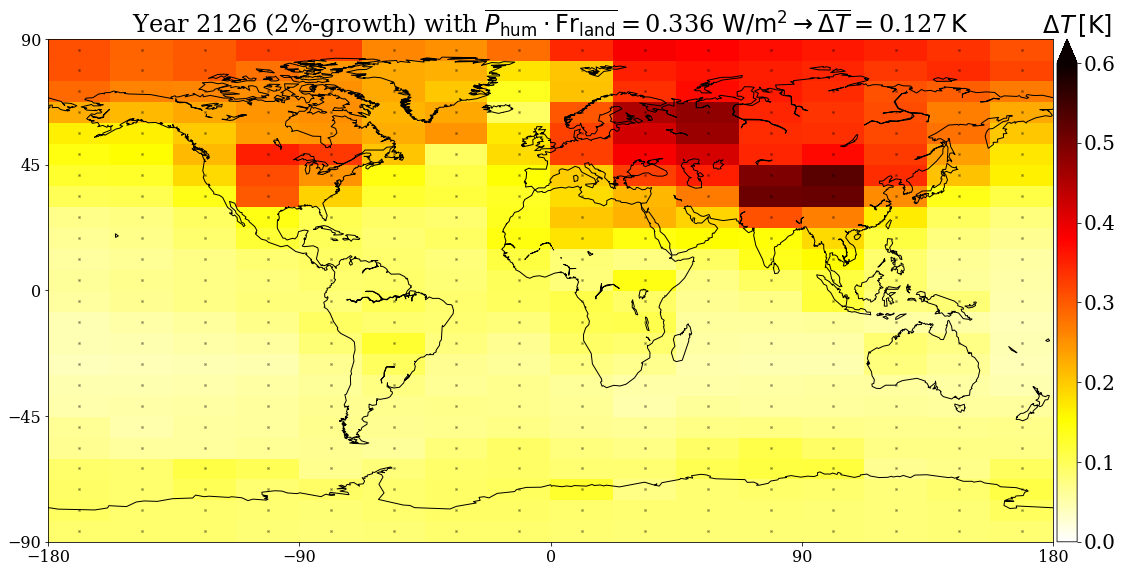

In [81]:
dT2010, P, P_years, plot_name, growth= run(mainfolder, reffolder, runname, refname, 2010, single, SSP, fut2250, historic, country, opt)
dT2126, P, P_years, plot_name, growth= run(mainfolder, reffolder, runname, refname, 2126, single, SSP, fut2250, historic, country, opt)
plot("diffTemp_2126-2010", 2126, dT2126-dT2010, P,P_years, growth)

## Do this in a loop

In [82]:
single=False
SSP=False
fut2250=False
historic=False
opt="1WB"
refname="hom_REF"#"RESTandREF_fourth"


### FULL 2100 2010, SSP 2100

('This figure is saved as ', 'dT_map_sol2_hom_P-2Pr')
('max P_hum', 2.6954069961726925)
('max Temperature difference:', 0.46081256866455078)
('This figure is saved as ', 'dT_map_sol2_hom_P-2Pr_historic')
('max P_hum', 2.6954069961726925)
('max Temperature difference:', 0.21039175987243652)
('This figure is saved as ', 'dT_map_sol2_hom_P-SSP5_opt1WB')
('max P_hum', 1.7110070374599999)
('max Temperature difference:', 0.31462717056274414)


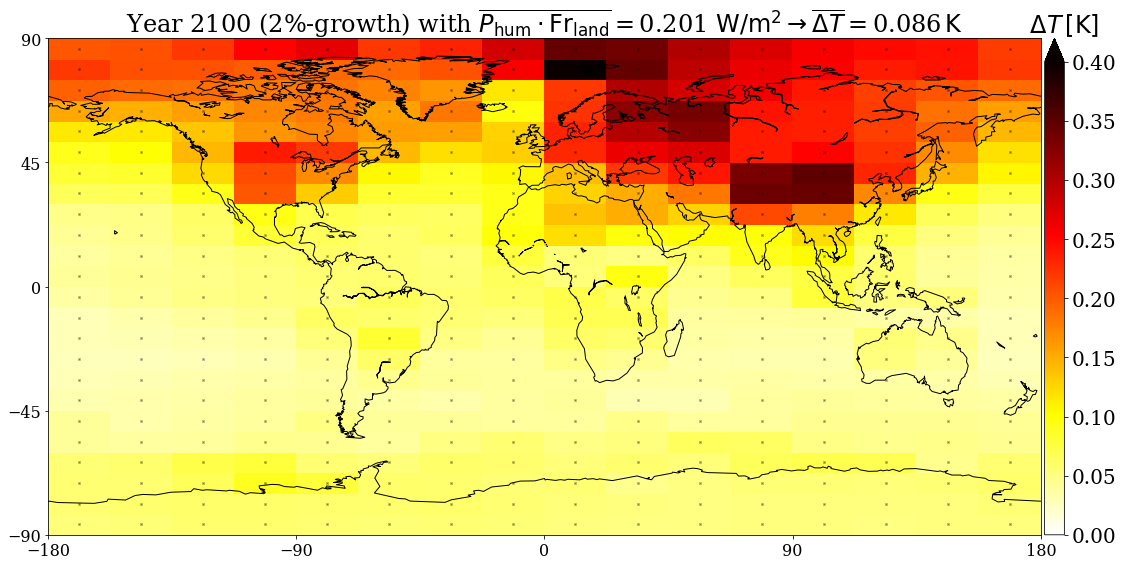

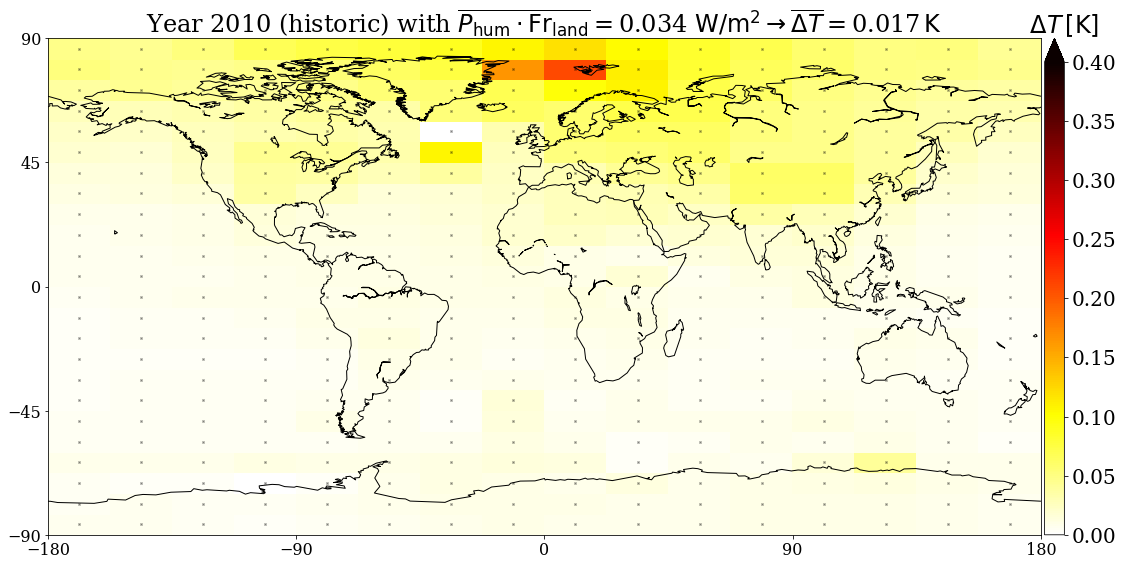

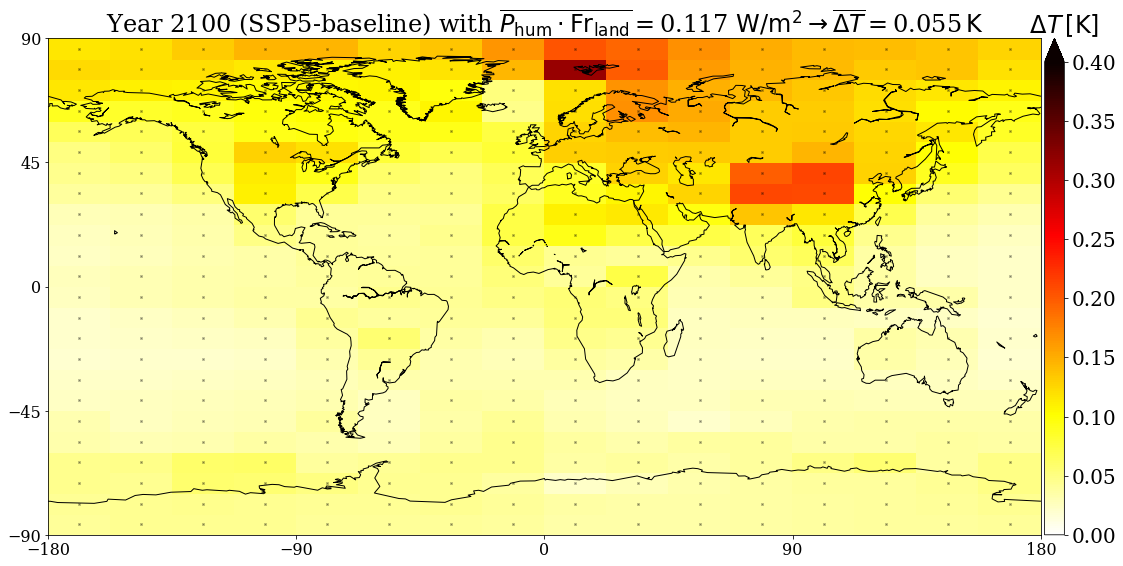

In [83]:
#runname="FULL_sol2_2pr_constForc_Mai8"
runname="hom_P-2Pr"
diff, P, P_years, plot_name, growth=run(mainfolder, reffolder, runname, refname, 2100, single, SSP, fut2250, historic, country, opt)
plot(plot_name, 2100, diff, P,P_years, growth)
diff, P, P_years, plot_name, growth=run(mainfolder, reffolder, runname, refname, 2010, single, SSP, fut2250, True, country, opt)
plot(plot_name, 2010, diff, P,P_years, growth)
runname="hom_P-SSP5_opt"+opt
diff, P, P_years, plot_name, growth=run(mainfolder, reffolder, runname, refname, 2100, single, True, fut2250, historic, country, opt)
plot(plot_name, 2100, diff, P,P_years, growth)

In [84]:
#np.max(diff)
#dT[16,3+8]

### Singles

('This figure is saved as ', 'dT_map_hom_singleAU_2_perc')
('max P_hum', 88.055243339279528, ', spread on landfrac:', array([[ 0.67031235]]))
('max Temperature difference:', 1.4007530212402344)
('This figure is saved as ', 'dT_map_hom_singleAM_2_perc')
('max P_hum', 87.312946011803973, ', spread on landfrac:', array([[ 0.74760759]]))
('max Temperature difference:', 1.7624597549438477)
('This figure is saved as ', 'dT_map_hom_singleEU_2_perc')
('max P_hum', 74.432987900474799, ', spread on landfrac:', array([[ 1.]]))
('max Temperature difference:', 2.1833772659301758)
('This figure is saved as ', 'dT_map_hom_singleSH_2_perc')
('max P_hum', 177.07267993170791, ', spread on landfrac:', array([[ 0.33333334]]))
('max Temperature difference:', 1.39111328125)
('This figure is saved as ', 'dT_map_hom_singleVA_2_perc')
('max P_hum', 128.28312284461592, ', spread on landfrac:', array([[ 0.58022261]]))
('max Temperature difference:', 1.7066059112548828)


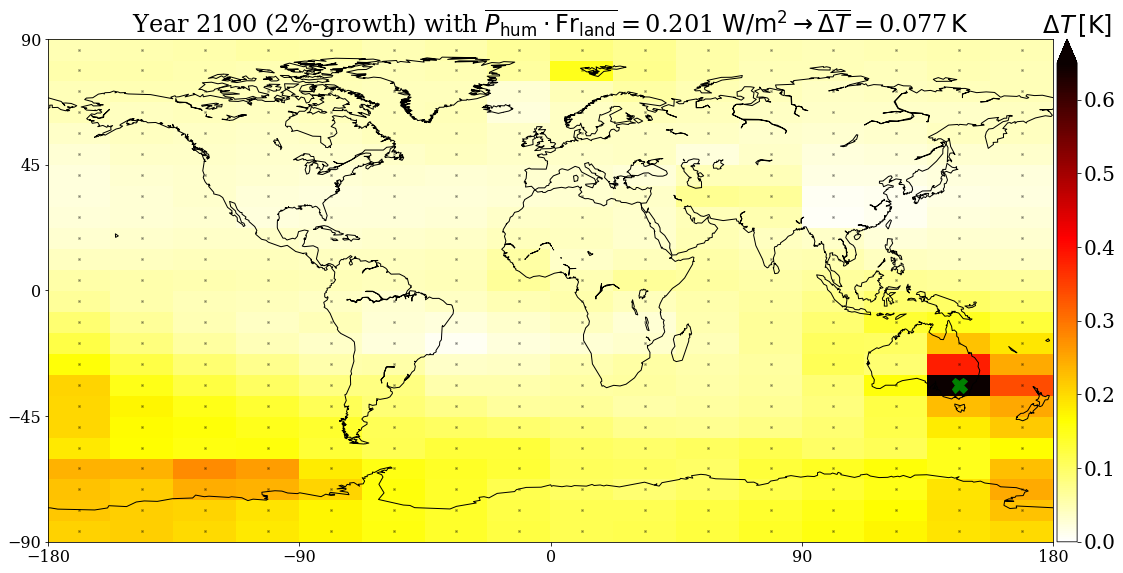

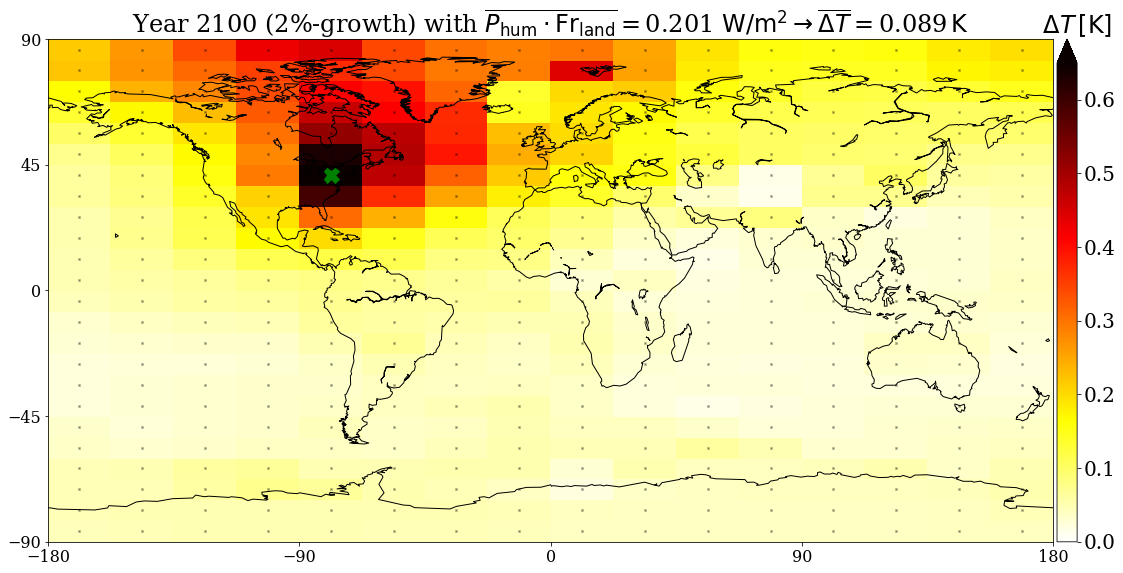

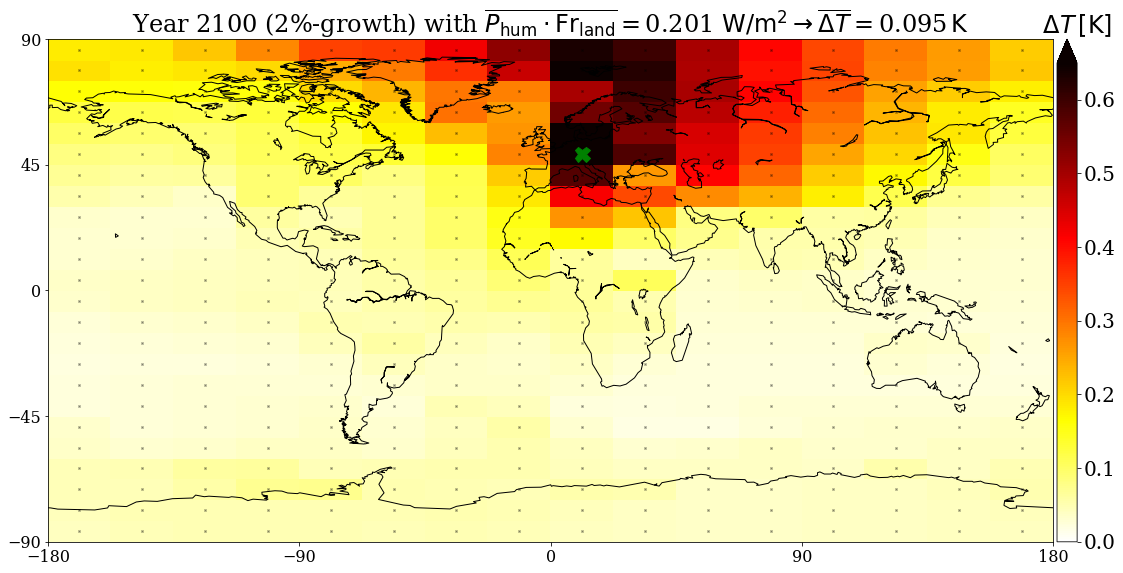

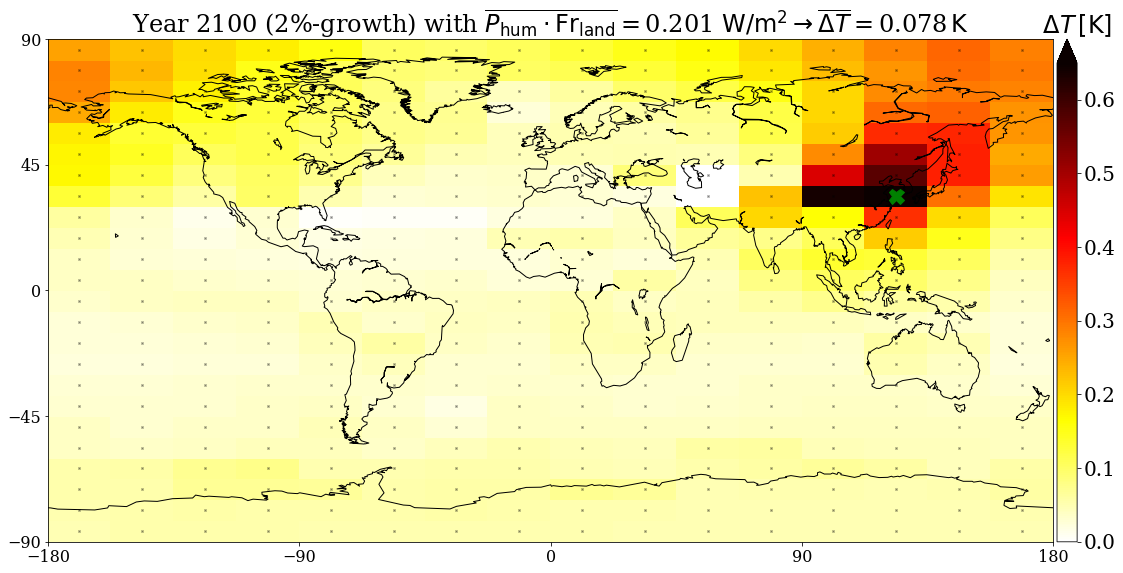

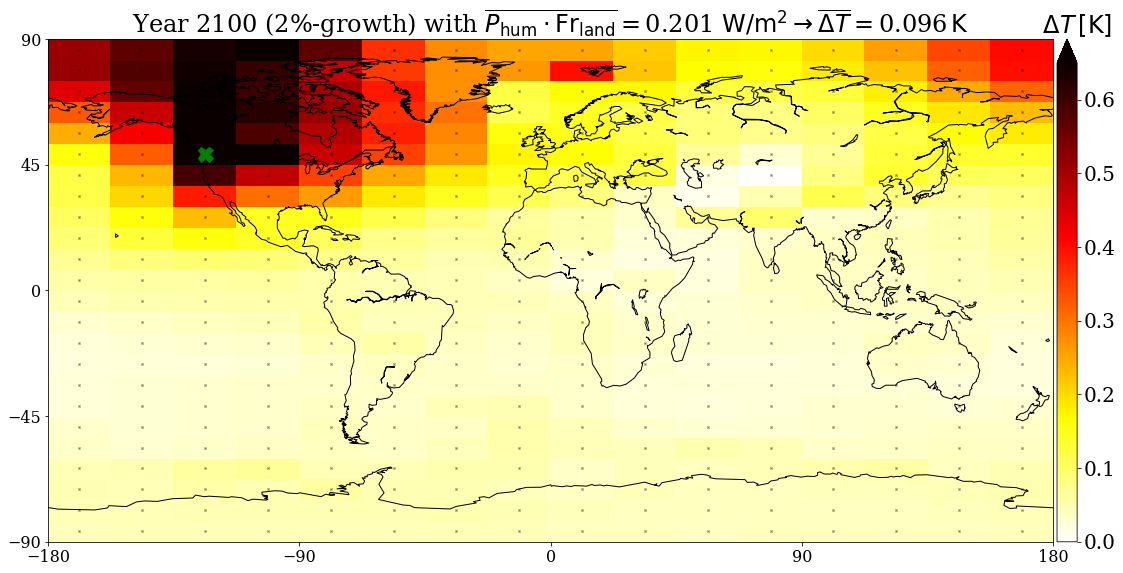

In [85]:
dT=[]
single=True
for country in ["AU", "AM", "EU", "SH", "VA"]:
    runname="hom_single"+country+""
    diff, P, P_years, plot_name, growth = run(mainfolder, reffolder, runname, refname, 2100, True, SSP, fut2250, historic, country, opt)
    plot(plot_name, 2100, diff, P,P_years, growth)
    dT.append(diff)
single=False

## Future

In [86]:
#single=False
#fut2250=True
#historic=False
#SSP=False

In [87]:
#runname="hom_P-2Pr_rev"
#dT=run(mainfolder, reffolder, runname, refname, single, SSP, fut2250, historic, country, opt)
#runname="hom_P-2Pr_furthergrowth"
#dT=run(mainfolder, reffolder, runname, refname, single, SSP, fut2250, historic, country, opt)
#runname="hom_P-2Pr_const"
#dT=run(mainfolder, reffolder, runname, refname, single, SSP, fut2250, historic, country, opt)

### Large Fluctuations

('This figure is saved as ', 'Map_T_y1950')
('max P_hum', 2.6954069961726925)
('max Temperature difference:', 0.54286575317382812)
('This figure is saved as ', 'Map_T_y1960')
('max P_hum', 2.6954069961726925)
('max Temperature difference:', 0.29714798927307129)


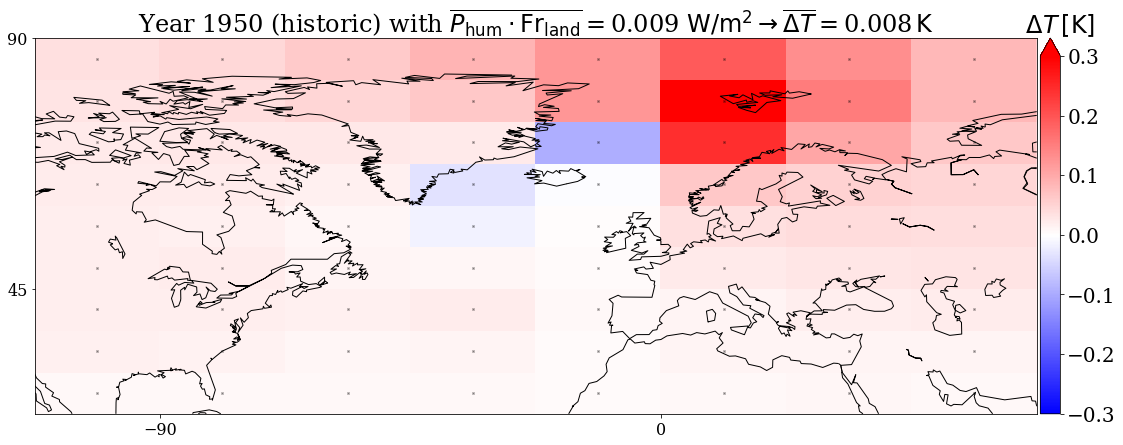

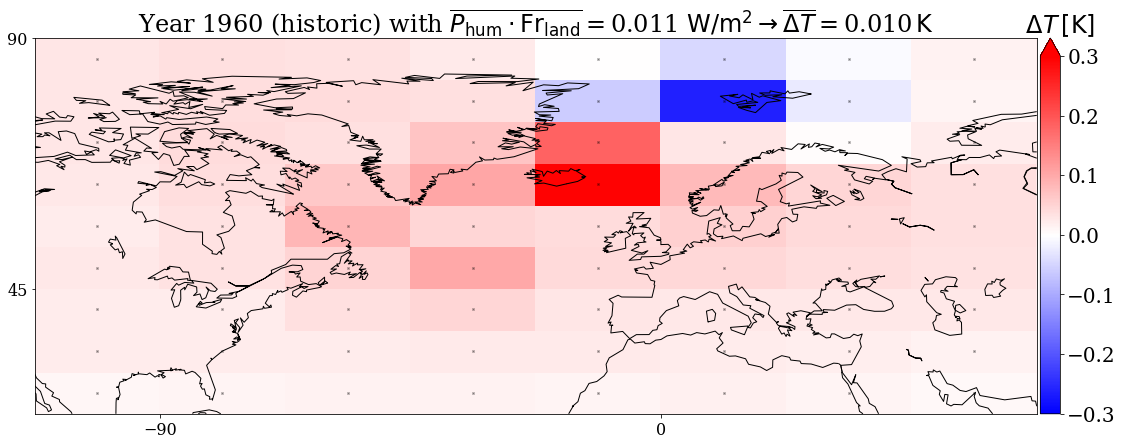

In [65]:
runname="hom_P-2Pr"
for y in [1950, 1960]:
    dT_fluc, P, P_years, plot_name, growth=run(mainfolder, reffolder, runname, refname, y, False, SSP, fut2250, True, country, opt)
    plot("Map_T_y"+str(y), y, dT_fluc, P,P_years, growth, gyre=True)

In [66]:
cs=["AU", "AM", "EU", "SH", "VA"]
for i in range(0,len(cs)):
    print(cs[i], np.max(dT[i].values))

('AU', 1.4007530212402344)
('AM', 1.7624597549438477)
('EU', 2.1833772659301758)
('SH', 1.39111328125)
('VA', 1.7066059112548828)


In [67]:
print(np.max(dT[0]))
print(np.where(dT[0]== np.max(dT[0])))

<xarray.DataArray 'ts_ann' ()>
array(1.4007530212402344)
Coordinates:
    Time     float64 1.983e+07
(array([7]), array([6]))


In [68]:
print(dT[0][7,14])
print(dT[0][6,14])
print(dT[0][5,14])

<xarray.DataArray 'ts_ann' ()>
array(0.05496978759765625)
Coordinates:
    Time     float64 1.983e+07
    xt_i     float32 326.25
    yt_j     float32 -33.75
<xarray.DataArray 'ts_ann' ()>
array(0.07776069641113281)
Coordinates:
    Time     float64 1.983e+07
    xt_i     float32 326.25
    yt_j     float32 -41.25
<xarray.DataArray 'ts_ann' ()>
array(0.10384225845336914)
Coordinates:
    Time     float64 1.983e+07
    xt_i     float32 326.25
    yt_j     float32 -48.75


In [69]:
print(np.max(dT[3]))
print(np.where(dT[3]== np.max(dT[3])))

<xarray.DataArray 'ts_ann' ()>
array(1.39111328125)
Coordinates:
    Time     float64 1.983e+07
(array([16]), array([5]))


In [70]:
print(dT[3][16,13])
print(dT[3][17,13])
print(dT[03][15,13])

<xarray.DataArray 'ts_ann' ()>
array(0.028429031372070312)
Coordinates:
    Time     float64 1.983e+07
    xt_i     float32 303.75
    yt_j     float32 33.75
<xarray.DataArray 'ts_ann' ()>
array(0.04485511779785156)
Coordinates:
    Time     float64 1.983e+07
    xt_i     float32 303.75
    yt_j     float32 41.25
<xarray.DataArray 'ts_ann' ()>
array(0.0063953399658203125)
Coordinates:
    Time     float64 1.983e+07
    xt_i     float32 303.75
    yt_j     float32 26.25


In [71]:
for i in range(0,len(cs)):
    print(cs[i], dT[i][22,8])

('AU', <xarray.DataArray 'ts_ann' ()>
array(0.05540752410888672)
Coordinates:
    Time     float64 1.983e+07
    xt_i     float32 191.25
    yt_j     float32 78.75)
('AM', <xarray.DataArray 'ts_ann' ()>
array(0.22162818908691406)
Coordinates:
    Time     float64 1.983e+07
    xt_i     float32 191.25
    yt_j     float32 78.75)
('EU', <xarray.DataArray 'ts_ann' ()>
array(0.19320964813232422)
Coordinates:
    Time     float64 1.983e+07
    xt_i     float32 191.25
    yt_j     float32 78.75)
('SH', <xarray.DataArray 'ts_ann' ()>
array(0.2864227294921875)
Coordinates:
    Time     float64 1.983e+07
    xt_i     float32 191.25
    yt_j     float32 78.75)
('VA', <xarray.DataArray 'ts_ann' ()>
array(0.5129289627075195)
Coordinates:
    Time     float64 1.983e+07
    xt_i     float32 191.25
    yt_j     float32 78.75)
